# Graphenexploration: Anwendungen

## Graphen

Wir verwenden hier wieder `networkx` zur Repräsentation und zur Darstellung von Graphen:

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

edges = [(0,1), (0,3), (1,2), (1,3), (2,4), (2,5), (3,2), (3,4), (4,1), (4,5)]

directed_graph = nx.DiGraph()
directed_graph.add_nodes_from([0,1,2,3,4,5])
directed_graph.add_edges_from(edges)

undirected_graph = nx.Graph()
undirected_graph.add_nodes_from([0,1,2,3,4,5])
undirected_graph.add_edges_from(edges)

# g = nx.gnm_random_graph(8, 16, directed=True)

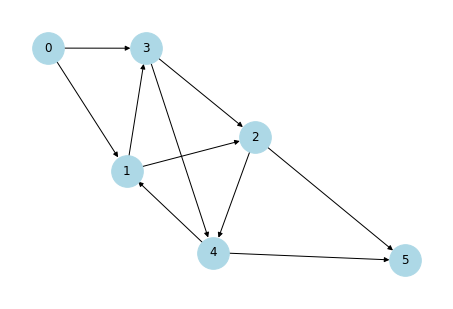

In [3]:
pos_dir = nx.spring_layout(directed_graph)
nx.draw(directed_graph, pos_dir, with_labels=True, node_size=1000, node_color='lightblue')

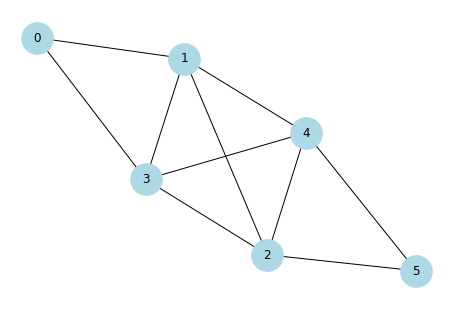

In [4]:
pos = nx.spring_layout(undirected_graph)
nx.draw(undirected_graph, pos, with_labels=True, node_size=1000, node_color='lightblue')

## Tiefen- und Breitensuche

Da wir sie für die Anwendungen brauchen, sind hier nochmal die Implementierungen der Tiefen- und der Breitensuche vom letzten Mal (da wir sie später benötigen, speichert die Tiefensuche aber die umgekehrte Postorderreihenfolge der Knoten).

In [5]:
from collections import deque

def depth_first_exploration(graph, node, visited=None,
                            reverse_postorder=deque):
    if visited is None:
        visited = set()
    if node in visited:
        return
    visited.add(node)
    
    for s in graph.successors(node):
        depth_first_exploration(graph, s, visited, 
                                reverse_postorder)
    reverse_postorder.appendleft(node)

order = deque()
depth_first_exploration(directed_graph, 0, reverse_postorder=order)
print(order)

deque([0, 1, 3, 2, 4, 5])


In [6]:
def bfs_with_predecessors(graph, node):
    predecessor = dict()
    queue = deque()
    # use self-loop for start node
    predecessor[node] = node
    queue.append(node)
    while queue:
        v = queue.popleft()
        for s in graph.successors(v):
            if s not in predecessor:
                predecessor[s] = v
                queue.append(s)
    return predecessor

## Zusammenhangskomponenten ungerichteter Graphen

Zwei Knoten $u$ und $v$ sind in der gleichen Zusammenhangskomponente, wenn es einen Pfad zwischen $u$ und $v$ gibt.

In [8]:
class ConnectedComponents:
    def __init__(self, graph):
        self.id = dict()
        self.curr_id = 0
        visited = set()
        for node in graph.nodes:
            if node not in visited:
                self.dfs(graph, node, visited)
                self.curr_id += 1

    def dfs(self, graph, node, visited):
        if node in visited:
            return
        visited.add(node)
        self.id[node] = self.curr_id
        for n in graph.neighbors(node):
            self.dfs(graph, n, visited)
            
    def connected(self, node1, node2):
        return self.id[node1] == self.id[node2]

    def count(self):
        return self.curr_id


<span style="color:red">*Aufgabe*</span>: Vervollständigen Sie die Implementierung von `connected` und `count`.

Der Graph hat 3 Zusammenhangskomponenten.
Knoten 0 und 4 sind verbunden? True
Knoten 3 und 7 sind verbunden? False


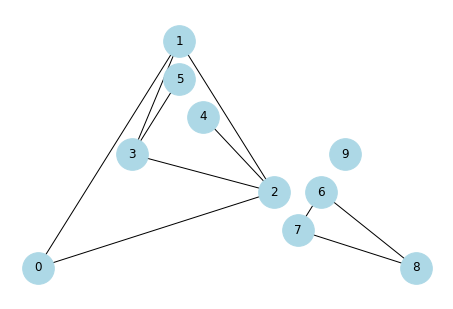

In [9]:
cc_undirected = nx.Graph()
cc_undirected.add_nodes_from([0,1,2,3,4,5,6,7,8,9])
edges_cc_undirected = [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,5), (6,7), (6,8), (7,8)]
cc_undirected.add_edges_from(edges_cc_undirected)

pos = nx.planar_layout(cc_undirected)
nx.draw(cc_undirected, pos, with_labels=True, node_size=1000, node_color='lightblue')

cc = ConnectedComponents(cc_undirected)
print("Der Graph hat", cc.count(), "Zusammenhangskomponenten.")
print("Knoten 0 und 4 sind verbunden?", cc.connected(0,4))
print("Knoten 3 und 7 sind verbunden?", cc.connected(3,7))

## Starke Zusammenhangskomponenten gerichteter Graphen

Wir erstellen zunächst einmal einen Beispielgraphen:

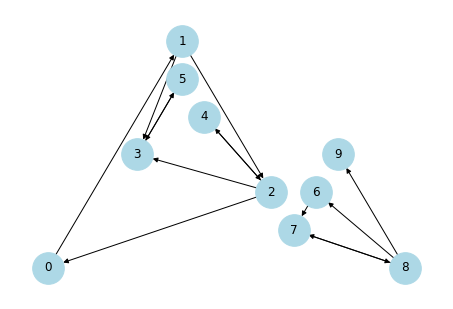

In [10]:
scc_example = nx.DiGraph()
scc_example.add_nodes_from([0,1,2,3,4,5,6,7,8,9])
edges_scc = [(0,1), (1,2), (1,3), (2,0), (2,3), (2,4), (3,5),
             (4,2), (5,3), (6,7), (7,8), (8,6), (8,7), (8,9)]
scc_example.add_edges_from(edges_scc)

pos = nx.planar_layout(scc_example)
nx.draw(scc_example, pos, with_labels=True, node_size=1000, node_color='lightblue')

Zur Berechnung der starken Zusammenhangskomponenten verwenden wir den Algorithmus von Kosaraju:

In [11]:
def compute_strongly_connected_components(directed_graph):
    reversed_graph = directed_graph.reverse(False)
    
    # compute complete reverse postorder for reversed graph
    visited = set()
    reverse_postorder = deque()
    for node in reversed_graph.nodes:
        depth_first_exploration(reversed_graph, node, visited,
                                reverse_postorder)
        
    # determine strongly connected components
    sccs = []    

    visited = set()
    for node in reverse_postorder:
        if node not in visited:
            newly_visited = deque()
            depth_first_exploration(directed_graph, node,
                                    visited,
                                    newly_visited)
            sccs.append(newly_visited)
    
    return sccs

<span style="color:red">*Aufgabe*</span>: Vervollständigen Sie die Implementierung von `compute_strongly_connected_components`.

Zum Testen färben wir den Testgraphen entsprechend ein:

[deque([9]), deque([6, 7, 8]), deque([3, 5]), deque([0, 1, 2, 4])]


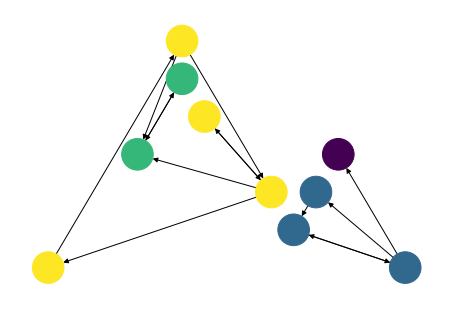

In [13]:
sccs = compute_strongly_connected_components(scc_example)
print(sccs)

node_to_component_no = dict()
for no, component in enumerate(sccs):
    for node in component:
        node_to_component_no[node] = no
        
nodelist = list(scc_example.nodes)
colors = [node_to_component_no[n] for n in nodelist]

nx.draw(scc_example, pos, node_list=nodelist, node_size=1000, node_color=colors)


## Kürzeste Pfade

Für ungewichtete Graphen können wir kürzeste Pfade einfach mit Hilfe einer Breitensuche bestimmen, die sich die Vorgänger im induzierten Suchbaum merkt. Den Pfad extrahiert man dann rückwärts vom Ziel- zum Startknoten.

Da wir den Pfad gleich auch zeichnen wollen, speichern wir nicht die Sequenz der Knoten, sondern die Sequenz der Kanten.

In [14]:
def shortest_path(graph, from_node, to_node):
    # more efficient: stop bfs as soon to_node has been visited
    predecessor = bfs_with_predecessors(directed_graph, from_node)
    if to_node not in predecessor:
        print("There is no path from", from_node, "to", to_node)
        return None
    
    path = deque()
    current_node = to_node
    pre = predecessor[current_node]
    while pre != current_node:
        path.appendleft((pre, current_node))
        current_node = pre
        pre = predecessor[current_node]
    return path

deque([(0, 1), (1, 2), (2, 5)])


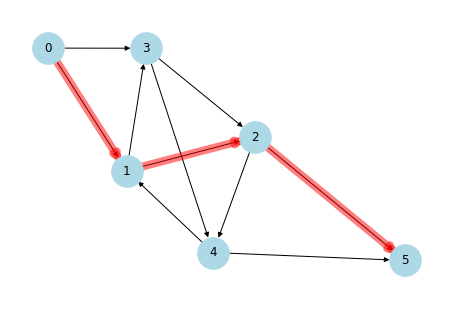

In [15]:
path = shortest_path(directed_graph, 0, 5)
print(path)
if path is not None:
    nx.draw(directed_graph, pos_dir, with_labels=True, node_size=1000, node_color='lightblue')
    _ = nx.draw_networkx_edges(directed_graph, pos_dir, edgelist=path, width=8, alpha=0.5, edge_color="red")


## Zyklen

Ein gerichteter, azyklischer Graph (directed acyclic graph, DAG) ist ein gerichteter Graph, der keine gerichteten Zyklen enthält. Zum Beispiel:

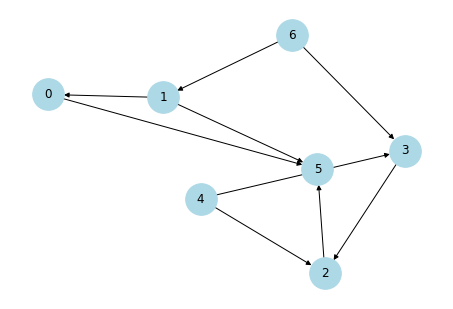

In [19]:
dag = nx.DiGraph()
dag.add_nodes_from([0,1,2,3,4,5,6])
dag.add_edges_from([(0,5),(1,0),(1,5),(2,5),(3,2),(4,2),(4,3),(6,1),(6,3)])

pos_dag = nx.spring_layout(dag)
nx.draw(dag, pos_dag, with_labels=True, node_size=1000, node_color='lightblue')

Die Zykeldetektion besteht auf einer Reihe von Tiefensuchen, die den induzierten Suchbaum auf Rückwärtskanten prüft.

In [16]:
class DirectedCycle:
    def __init__(self, graph):
        self.predecessor = dict()
        self.on_current_path = set()
        self.cycle = None
        for node in graph.nodes:
            if self.has_cycle():
                break
            if node not in self.predecessor:
                self.predecessor[node] = node
                self.dfs(graph, node)

    def has_cycle(self):
        return self.cycle is not None

    def dfs(self, graph, node):
        self.on_current_path.add(node)
        for s in graph.successors(node):
            if self.has_cycle():
                return
            if s in self.on_current_path:
                self.predecessor[s] = node
                self.extract_cycle(s)
            if s not in self.predecessor:
                self.predecessor[s] = node
                self.dfs(graph, s)
        self.on_current_path.remove(node)
        
    def extract_cycle(self, node):
        self.cycle = deque()
        current = node
        self.cycle.appendleft(current)
        while True:
            current = self.predecessor[current]
            self.cycle.appendleft(current)
            if current == node:
                return    

Hat der DAG einen Zyklus? False
Hat der andere gerichtete Graph einen Zyklus? True
deque([1, 2, 4, 1])


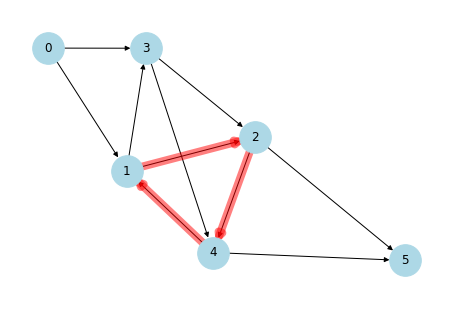

In [20]:
cycle_detector = DirectedCycle(dag)
print("Hat der DAG einen Zyklus?", cycle_detector.has_cycle())
cycle_detector = DirectedCycle(directed_graph)
print("Hat der andere gerichtete Graph einen Zyklus?", cycle_detector.has_cycle())
cycle = cycle_detector.cycle
print(cycle)

path = [(cycle[i], cycle[i+1]) for i in range(len(cycle)-1)]
nx.draw(directed_graph, pos_dir, with_labels=True, node_size=1000, node_color='lightblue')
_ = nx.draw_networkx_edges(directed_graph, pos_dir, edgelist=path, width=8, alpha=0.5, edge_color="red")


## Topologische Sortierung

Eine topologische Sortierung eines azyklischen, gerichteten Graphen ist eine Knotenreihenfolge, bei er es keine Kante von einem "späteren" zu einem "früheren" Knoten gibt.

Zur Berechnung verwenden wir einfach eine Folge von Tiefensuchen und extrahieren eine vollständige umgekehrte Postorderreihenfolge (analog zu Kosaraju).

In [ ]:
def topological_sort(acyclic_digraph):
    visited = set()
    reverse_postorder = deque()
    for node in acyclic_digraph.nodes:
        depth_first_exploration(acyclic_digraph, node, visited, reverse_postorder)
    return reverse_postorder

In [ ]:
top = topological_sort(dag)
print(top)
nx.draw(dag, pos_dag, with_labels=True, node_size=1000, node_color='lightblue')